## Introduction

In this project we are going to examine different factors in the Northwind database and their influence on sales.  We will be exploring the effects of discounts, order frequency and individual employees on the quantities of items sold and the average prices of orders.  The Northwind Database contains sample sales records for a company named "Northwind Traders." Below is a schema for the shape of the database.

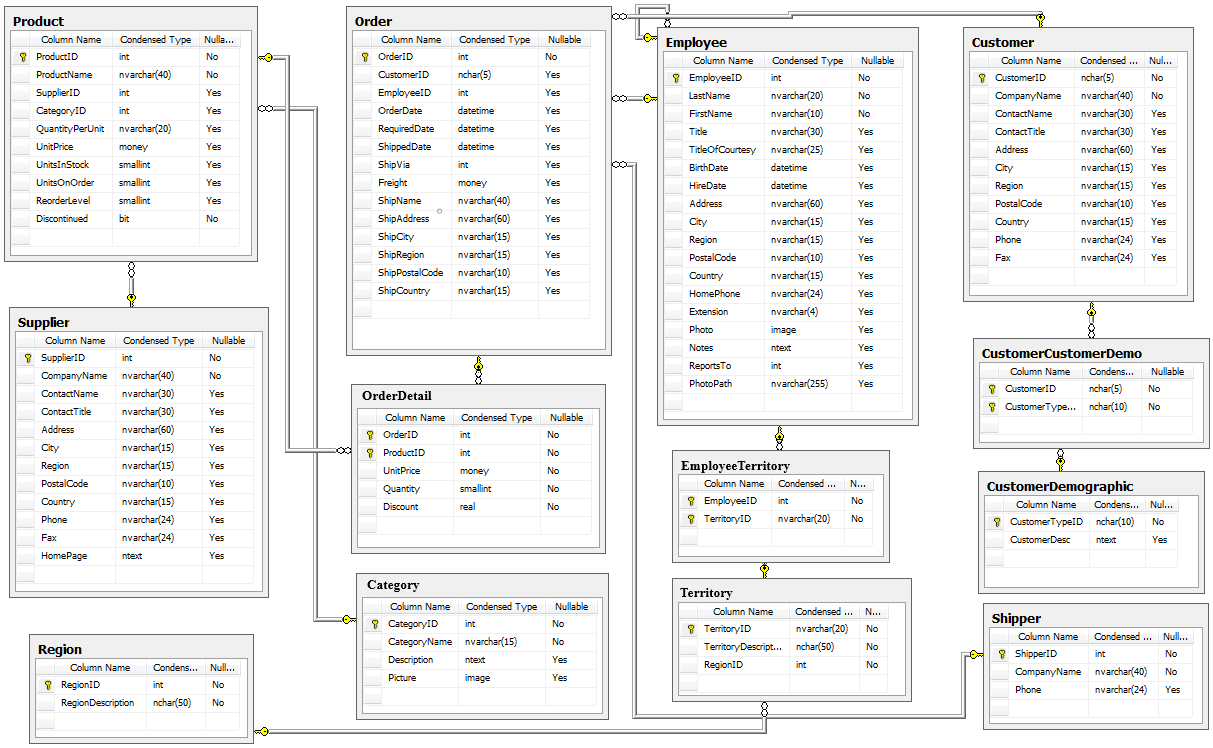

The project will be broken down into individual questions and each question will follow a similar pattern.  We will present the null and alternate hypothesis, collect our sample, examine and clean our data, then test the data to determine an effect.  We will use a variety of tests to examine the data.

Before we begin, we will import any relevant libraries, connect to our database and write a few functions to streamline our work.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlite3
sns.set_style('darkgrid')
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

## Connecting to Database

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

## Define Helper Functions

In [3]:
# Def a SQL helper function to convert whole tables into DataFrames:
def SQL_reader(table):
    c.execute("""select * from {}""".format(table))
    df = pd.DataFrame(c.fetchall())
    df.columns = [x[0] for x in c.description]
    return df

# Def a function to join SQL tables and return a DataFrame
def SQL_joiner(selected, tables, joins, groupby=None, verbose=False):
    # Takes several lists of strings.
        # Selected is the list of columns the DataFrame will contain.  It should include aggregates and aliases.
        # Tables is a list of tables to join. Again, include any aliases.
        # Joins is a list of keys to join tables. Account for table aliases and different names between tables. I.e. 'o.Id = od.OrderId' 
    # The function will build a string that will be used to query a database
    # To start, the function selects the first column:
    query = "select {}".format(selected[0])
    # Next, the query adds the rest of the columns:
    for i, v in enumerate(selected):
        if i == 0:
            pass
        else:
            query += ", {}".format(v)
    # The query then selects the first table:
    query += " from {}".format(tables[0])
    # Then the query joins each additional table on the indicated column:
    for i, v in enumerate(joins):
        query += " join {} on {}".format(tables[i+1], v)
    # Finally the query will group the data if requested:
    if groupby:
        query += " group by {}".format(groupby)
    # If verbose, the function will print the entire query:
    if verbose:
        print(query)
    # The completed query is passed to the database and the result is converted into a DataFrame:
    c.execute(query)
    df = pd.DataFrame(c.fetchall())
    df.columns = [x[0] for x in c.description]
    return df

Before we get too far in, we will print the first 10 rows of each table to see what the information looks like.

In [4]:
all_tables = ['Product', 'Supplier', '[Order]', 'OrderDetail', 'Category', 'Region', 
              'Employee', 'Territory', 'Customer', 'Shipper']
for table in all_tables:
    print(SQL_reader(table).head(10))

   Id                      ProductName  SupplierId  CategoryId  \
0   1                             Chai           1           1   
1   2                            Chang           1           1   
2   3                    Aniseed Syrup           1           2   
3   4     Chef Anton's Cajun Seasoning           2           2   
4   5           Chef Anton's Gumbo Mix           2           2   
5   6     Grandma's Boysenberry Spread           3           2   
6   7  Uncle Bob's Organic Dried Pears           3           7   
7   8       Northwoods Cranberry Sauce           3           2   
8   9                  Mishi Kobe Niku           4           6   
9  10                            Ikura           4           8   

       QuantityPerUnit  UnitPrice  UnitsInStock  UnitsOnOrder  ReorderLevel  \
0   10 boxes x 20 bags      18.00            39             0            10   
1   24 - 12 oz bottles      19.00            17            40            25   
2  12 - 550 ml bottles      10.00   

## Question 1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

We will begin by looking at the effect of discount on the quantity of items that are ordered.  This question will be broken down into two hypothesis.  The first will test for the effect of any discount on quantity.  If that test demonstrates a significant effect, then we will test different discount levels to determine at what levels the effect is noticeable.
### First Hypothesis
$H_O$: Discounted orders will have the same quantity of items as non-discounted orders.

$H_A$: Discounted orders will contain more items than non-discounted orders.

For this test we will run a one-tailed (only looking for a larger effect) t-test with an alpha level of 0.05.

### Querying the database and determining means of our samples

In [5]:
q1 = SQL_reader('OrderDetail')
q1['Discounted'] = q1.Discount.map(lambda x: 1 if x > 0 else 0)
q1.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Discounted
0,10248/11,10248,11,14.0,12,0.0,0
1,10248/42,10248,42,9.8,10,0.0,0
2,10248/72,10248,72,34.8,5,0.0,0
3,10249/14,10249,14,18.6,9,0.0,0
4,10249/51,10249,51,42.4,40,0.0,0


In [6]:
q1.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,Discounted
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167,0.388863
std,241.378032,22.159019,29.827418,19.022047,0.083450,0.487605
min,10248.000000,1.000000,2.000000,1.000000,0.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000,1.000000
max,11077.000000,77.000000,263.500000,130.000000,0.250000,1.000000


In [7]:
discounted = q1[q1.Discounted == 1]
not_discounted = q1[q1.Discounted == 0]

mD = round(np.mean(discounted.Quantity), 2)
nD = len(discounted)
mND = round(np.mean(not_discounted.Quantity), 2)
nND = len(not_discounted)
print('The mean quantity of discounted orders is {} and the sample size is {}'.format(mD, nD))
print('The mean quantity of non-discounted orders is {} and the sample size is {}'.format(mND, nND))
print('The mean difference is {}'.format(round(mD-mND, 2)))

The mean quantity of discounted orders is 27.11 and the sample size is 838
The mean quantity of non-discounted orders is 21.72 and the sample size is 1317
The mean difference is 5.39


### Exploratory Analysis

Before we run our t-test, we will look a graphical representations of our data.  First, we will look at the average quantity ordered with a discount and without a discount; then, we will break down this information by product ID to make sure that overall trends are present across multiple products.

Text(0.5, 1.0, 'Items Ordered by Discount')

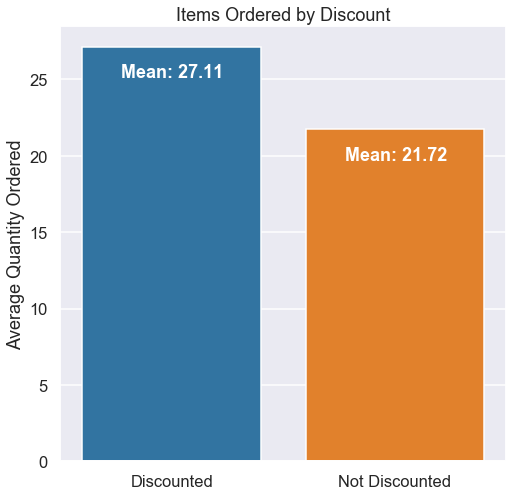

In [8]:
plt.figure(figsize=(8,8))
X = ['Discounted', 'Not Discounted']
y = [mD, mND]
sns.barplot(X, y)
for i, v in enumerate(y):
    plt.text(i-.225, v-2, 'Mean: '+str(v), color='white', fontweight='bold', size = 18)
plt.ylabel('Average Quantity Ordered')
plt.title('Items Ordered by Discount')

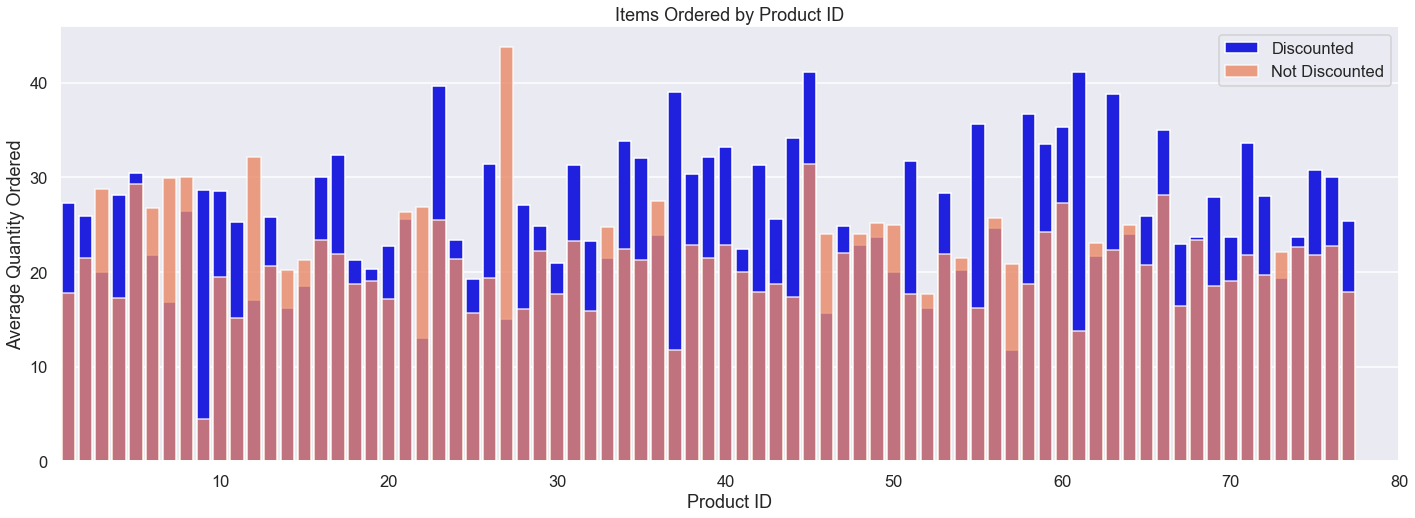

In [9]:
plt.figure(figsize=(24,8))
ticks=[9,19,29,39,49,59,69,79]
labels = [10,20,30,40,50,60,70,80]
sns.barplot(discounted.ProductId, discounted.Quantity, color='blue', label = 'Discounted', ci=None)
sns.barplot(not_discounted.ProductId, not_discounted.Quantity, color='coral', alpha=.8, label = 'Not Discounted', ci=None)
plt.xlabel('Product ID')
plt.ylabel('Average Quantity Ordered')
plt.title('Items Ordered by Product ID')
plt.xticks(ticks,labels)
plt.legend()
plt.show()

The graphs indicate that discounted orders generally contain a larger quantity of items, but let's determine if this is a significant difference.

### Welch's t-test

We will run Welch's t-test to determine a p-value that we can check against our alpha level. If this produces a significant effect, we will also determine an effect size (Cohen's d) to judge the magnitude of difference.

In [10]:
experimental = discounted.Quantity
control = not_discounted.Quantity
results = stats.ttest_ind(experimental, control, equal_var=False)
p = results[1]
print('p-value: {}'.format(p))

p-value: 5.65641429030433e-10


In [11]:
def Cohen_d(group1, group2):
    #calculate difference of means for numerator
    diff = group1.mean() - group2.mean()
    #calculate pooled variance for denomenator
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    d = diff / np.sqrt(pooled_var)
    
    return d
d = round(Cohen_d(experimental, control), 3)
print('Effect size: {}'.format(d))

Effect size: 0.286


We will reject the null hypothesis because our p-value is much lower than our alpha level of 0.05.  It appears that discounted orders do have a larger quantity of items ordered.  Our effect size is .286, so we have a small, though not inconsequential effect.  Let's see if we can determine what discount levels have a significant effect.

### Second Hypothesis

$H_O$:  The quantity of items ordered will be the same between all discount levels.

$H_A$:  The quantity of items ordered will not be the same between all discount levels.

For this test, we will run a one-way anova with an alpha level of 0.05.

### Exploratory Analysis

We will start by looking at the mean quantity for each discount level.

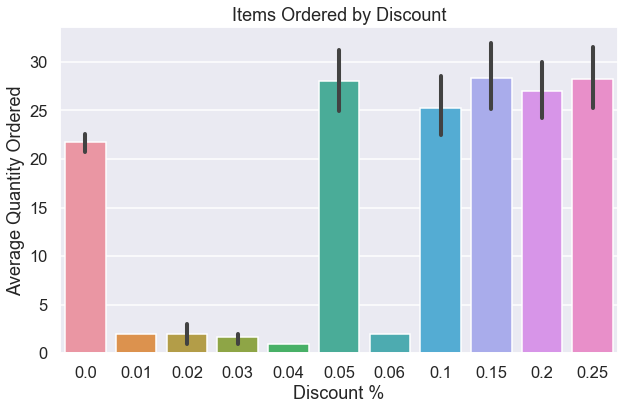

In [12]:
plt.figure(figsize=(10,6))
ax = sns.barplot(q1.Discount, q1.Quantity)
plt.xlabel('Discount %')
plt.ylabel('Average Quantity Ordered')
plt.title('Items Ordered by Discount')
plt.show()

I'm concerned about the small averages at discount levels 0.01, 0.02, 0.03, 0.04, and 0.06.  Those seem like unusual discounts that would not be applied to many orders.  I expect small sample sizes at those levels.  Lets investigate.

In [13]:
small_samples = [.01, .02, .03, .04, .06]
for i in small_samples:
    print('The number of orders with a {}% discount is {}'.format(i, sum(q1.Discount==i)))

The number of orders with a 0.01% discount is 1
The number of orders with a 0.02% discount is 2
The number of orders with a 0.03% discount is 3
The number of orders with a 0.04% discount is 1
The number of orders with a 0.06% discount is 1


As expected, there are very few orders at those levels.  Since we can not get a large enough sample size from these discount levels, we will exclude them from this test.  At this point we will also drop non-discounted data as we will not need it moving forward.

In [14]:
small_samples.append(0.0)
df2 = q1
for i in small_samples:
    df2.drop(df2.loc[df2['Discount']==i].index, inplace=True)
df2.Discount.value_counts()

0.05    185
0.10    173
0.20    161
0.15    157
0.25    154
Name: Discount, dtype: int64

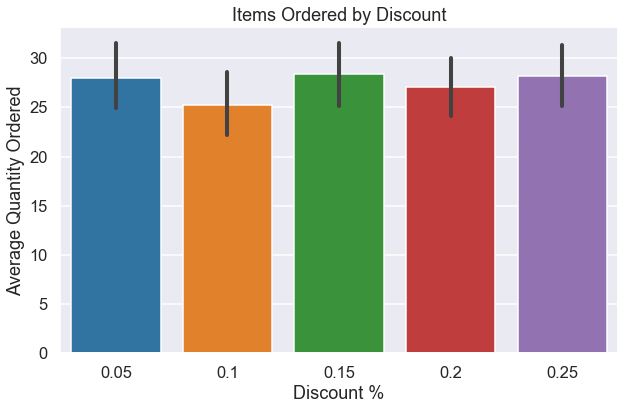

In [15]:
plt.figure(figsize=(10,6))
sns.barplot(df2.Discount, df2.Quantity)
plt.xlabel('Discount %')
plt.ylabel('Average Quantity Ordered')
plt.title('Items Ordered by Discount')
plt.show()

Thats better.  My first impression from the graph is that we will not have a significant difference between discount levels as the means are very close to each other.  To test this, we will run a one-way ANOVA.

### ANOVA

In [16]:
formula = 'Quantity ~ C(Discount)'
lm = ols(formula, df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(Discount),1159.517551,4.0,0.674103,0.610041
Residual,354768.342690,825.0,NaN,NaN


As expected, our p value of 0.61 is much higher than our critical value of .025.  We cannot reject the null hypothesis, and thus we assume all discount levels have a similar effect on quantities ordered.

### Question 1 Wrap Up

Discounted orders do contain higher quantities of items on average.  Further, this trend is visible in all levels of discount as there was no significant differences between means of discounted quantities.

## Question 2: Are repeat customers likely to have a higher discount? How does this vary based on the frequency of orders versus the amount the companies spend?

Next we want to see if returning customers are likely to get a discount.  We will look at two factors of the companies, the number of orders placed and the amount that the company has spent. We will again test two hypotheses for this question looking at how discount levels are affected by these independent variables.

### Query the database to retrieve our sample

In [17]:
selected = ['CompanyName as Company', 
            'count(distinct OrderId) as Num_Orders', 
            'Avg (Discount) as Average_Discount', 
            'sum (Quantity * UnitPrice * (1-Discount)) as Total_Spent']
tables = ['Customer c', '[Order] o', 'OrderDetail od']
joins = ['c.Id = o.CustomerId', 'o.Id = od.OrderId']
q2 = SQL_joiner(selected, tables, joins, groupby='Company', verbose=True)
q2.head()

select CompanyName as Company, count(distinct OrderId) as Num_Orders, Avg (Discount) as Average_Discount, sum (Quantity * UnitPrice * (1-Discount)) as Total_Spent from Customer c join [Order] o on c.Id = o.CustomerId join OrderDetail od on o.Id = od.OrderId group by Company


,Company,Num_Orders,Average_Discount,Total_Spent
0,Alfreds Futterkiste,6,0.087500,4273.0000
1,Ana Trujillo Emparedados y helados,4,0.000000,1402.9500
2,Around the Horn,13,0.023333,13390.6500
3,B's Beverages,10,0.000000,6089.9000
4,Berglunds snabbköp,18,0.057692,24927.5775


In [18]:
q2.describe()

,Num_Orders,Average_Discount,Total_Spent
count,85.000000,85.000000,85.000000
mean,9.423529,0.043199,14446.770171
std,5.880510,0.040297,20562.051784
min,1.000000,0.000000,100.800000
25%,5.000000,0.000000,3239.800000
50%,9.000000,0.041667,7176.215000
75%,12.000000,0.073077,16817.097500
max,31.000000,0.140000,110277.305000


### Exploratory Analysis

Before we outline our hypotheses, we will look at boxplots of our data to check for outlies.  We will look at the number of orders first.

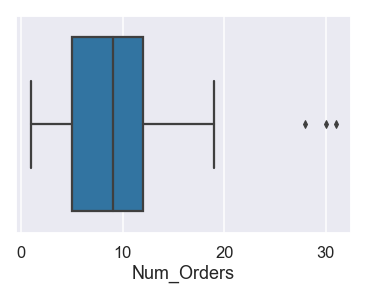

In [19]:
sns.boxplot(q2.Num_Orders)

It look like there are a few companies with many more orders than the rest.  Let's look at the boxplot for the amount that each company spent before we make any changes to the data.

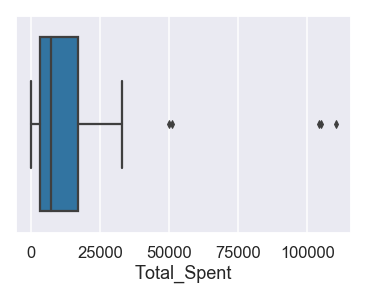

In [20]:
sns.boxplot(q2.Total_Spent)

Once again we have a few outliers. I have concerns that the outliers in both cases will skew the data since they are quite extreme.  Before we move on to testing the data we will remove companies that have spent more than $40,000 to see how this changes our dataset.

In [21]:
q2 = q2[q2.Total_Spent < 40000]
q2.describe()

,Num_Orders,Average_Discount,Total_Spent
count,80.000000,80.000000,80.000000
mean,8.437500,0.041289,10092.294069
std,4.251117,0.040287,8676.112472
min,1.000000,0.000000,100.800000
25%,5.000000,0.000000,3169.457500
50%,8.000000,0.040064,6757.737000
75%,11.000000,0.072815,15902.093750
max,19.000000,0.140000,32841.370000


It looks like there were only five companies that had more than $40,000 in total orders.  I'm comfortable removing those data points.  Let's reexamine our boxplots.

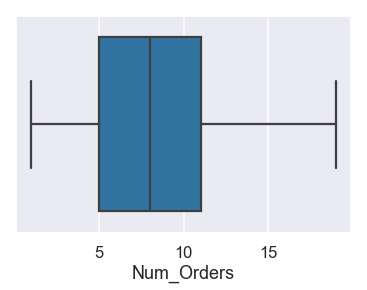

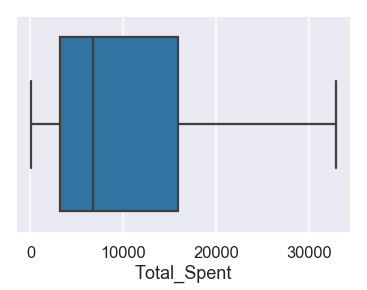

In [22]:
sns.boxplot(q2.Num_Orders)
plt.show()
sns.boxplot(q2.Total_Spent)
plt.show()

The data looks cleaner now. It looks like removing those five companies resolved our outliers in both respects. Now we are ready to test our data.

### First Hypothesis

$H_O$: All companies will have the same disount level

$H_A$: Companies with more orders will have a higher discount level

We will be conducting a one-tailed linear regression to test this hypothesis. We will again use an alpha level of .05.

In [23]:
formula = 'Average_Discount~Num_Orders'
model = ols(formula=formula, data=q2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Average_Discount   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     23.90
Date:                Fri, 11 Sep 2020   Prob (F-statistic):           5.31e-06
Time:                        14:39:06   Log-Likelihood:                 154.62
No. Observations:                  80   AIC:                            -305.2
Df Residuals:                      78   BIC:                            -300.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0026      0.009      0.289      0.773      -0.015       0.020
Num_Orders     0.0046      0.001      4.889      0.000       0.003       0.006
==============================================================================
Omnibus:                       12.766   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.739
Skew:                           0.987   Prob(JB):                      0.00104
Kurtosis:                       3.470   Cond. No.                         21.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With a p-value lower than .001 and a positive coefficient, we are able to reject the null hypothesis. Companies with more orders do have a significantly higher average discount rate. It is interesting to note that our interept is not significant with a p-value of .773; however, since there are no companies with zero orders, this is not a particularly useful metric. Let's chart the regression analysis to get a better idea of our effect.

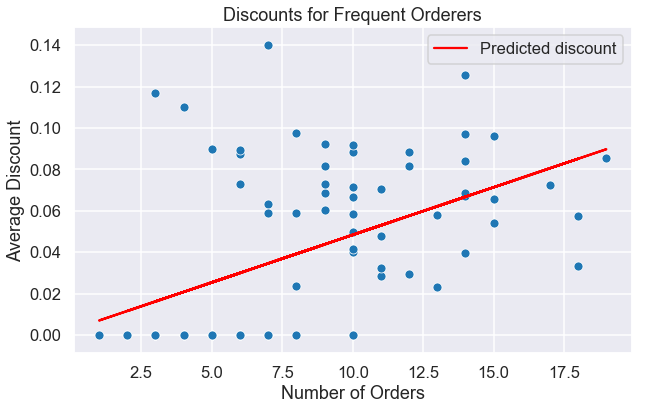

In [24]:
X = q2.Num_Orders
y = q2.Average_Discount
fig = plt.figure(figsize=(10,6))
sns.scatterplot(X, y)
plt.plot(X, model.predict(X), color='red', label = "Predicted discount")
plt.xlabel("Number of Orders")
plt.ylabel("Average Discount")
plt.title("Discounts for Frequent Orderers")
plt.legend()
plt.show()

With an $R^2$ of .235, we can see that the number of orders a company has placed with Northwind Traders has a significant, but not necessarily strong effect on discount. The variance in discount level is not adequately explained by our regression model.

### Second Hypothesis

Ho: All companies will have the same disount level.

Ha: Companies who have spent more will have a higher discount level.

We will also use a one-tailed linear regression analysis for this test.

In [25]:
formula2 = 'Average_Discount~Total_Spent'
model2 = ols(formula=formula2, data=q2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Average_Discount   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     21.51
Date:                Fri, 11 Sep 2020   Prob (F-statistic):           1.39e-05
Time:                        14:39:07   Log-Likelihood:                 153.67
No. Observations:                  80   AIC:                            -303.3
Df Residuals:                      78   BIC:                            -298.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0195      0.006      3.156      0.002       0.007       0.032
Total_Spent  2.159e-06   4.65e-07      4.638      0.000    1.23e-06    3.09e-06
==============================================================================
Omnibus:                       10.406   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               11.683
Skew:                           0.926   Prob(JB):                      0.00290
Kurtosis:                       2.722   Cond. No.                     2.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Again we have a p-value lower than our alpha level. We can reject the null hypothesis.  The amount that a company has spent does have a significant effect on discount level.  Let's look at a plot of this model.

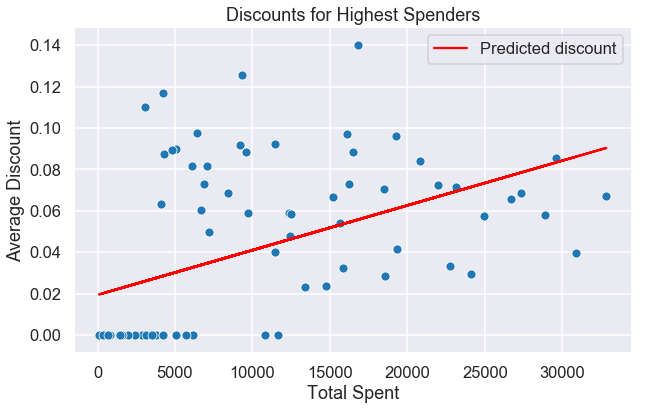

In [26]:
X = q2.Total_Spent
y = q2.Average_Discount
fig = plt.figure(figsize=(10,6))
sns.scatterplot(X, y)
plt.plot(X, model2.predict(X), color='red', label ="Predicted discount")
plt.xlabel("Total Spent")
plt.ylabel("Average Discount")
plt.title("Discounts for Highest Spenders")
plt.legend()
plt.show()

This model doesn't look any better than the first one.  Both the $R^2$ (.216) and the regression coefficient are smaller than those in the model with order frequency.  Overall this model also doesn't explain enough variance in discount levels to be satisfactory.

### Question 2 Wrap up

While both higher numbers of orders and higher spending at Northwind Traders had significantly higher discount levels, neither variable was particularly useful in determining discount levels.

## Question 3:  Are some employees statistically more likely than others to sell items when discounted? If so, does discount level have an effect?

Next, we want to see how the sales record of discounted items varies between employees. Is our sales team equally good at selling discounted products, or do some employees sell more than others?  For this question we will be looking at the quantities of discounted items sold by each employee as well as the discount levels of each order.

### Hypothesis:

$H_O$: The quantities of discounted items sold will be the same between employees.

$H_A$: Different employees will have different quantities of discounted items sold.

### Query the database to retrieve our sample

In [27]:
selected = ['EmployeeId', 'Discount', 'Quantity']
tables = ['Employee e', '[Order] o', 'OrderDetail od']
joins = ['e.Id = o.EmployeeId', 'o.Id = od.OrderId']
q3 = SQL_joiner(selected, tables, joins, verbose=True)
q3['Discounted'] = q3.Discount.map(lambda x: 1 if x > 0 else 0)
print(len(q3))
q3.head()

select EmployeeId, Discount, Quantity from Employee e join [Order] o on e.Id = o.EmployeeId join OrderDetail od on o.Id = od.OrderId
2155


,EmployeeId,Discount,Quantity,Discounted
0,5,0.0,12,0
1,5,0.0,10,0
2,5,0.0,5,0
3,6,0.0,9,0
4,6,0.0,40,0


### Exploratory Analysis

First we will look at a bar chart of discounted items versus non discounted items broken down by employee ID numbers. This will give us an idea of how sales change for each employee when items are discounted.

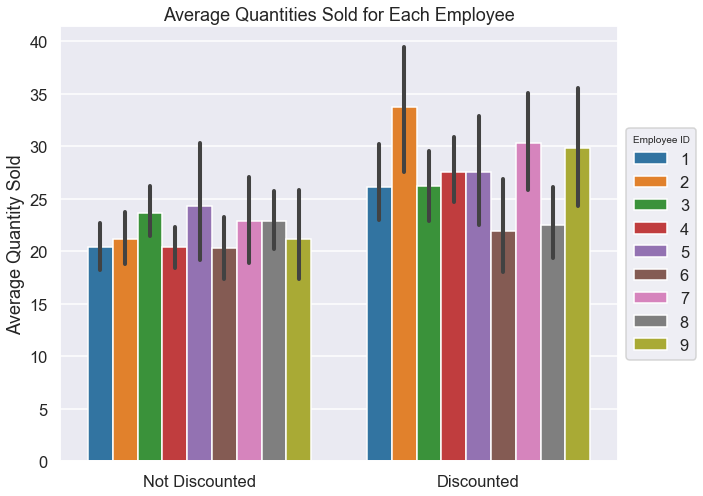

In [28]:
plt.figure(figsize = (10,8))
bars = sns.barplot(x=q3.Discounted.map(lambda x: 'Discounted' if x==1 else "Not Discounted"), y=q3.Quantity, hue=q3.EmployeeId)
plt.title("Average Quantities Sold for Each Employee")
plt.ylabel("Average Quantity Sold")
plt.xlabel("")
bars.legend(title='Employee ID', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

It looks like most employees have somewhat improved sales when items are discounted, but some make large jumps.  Lets break this chart down further by looking at each discount level by employee ID.

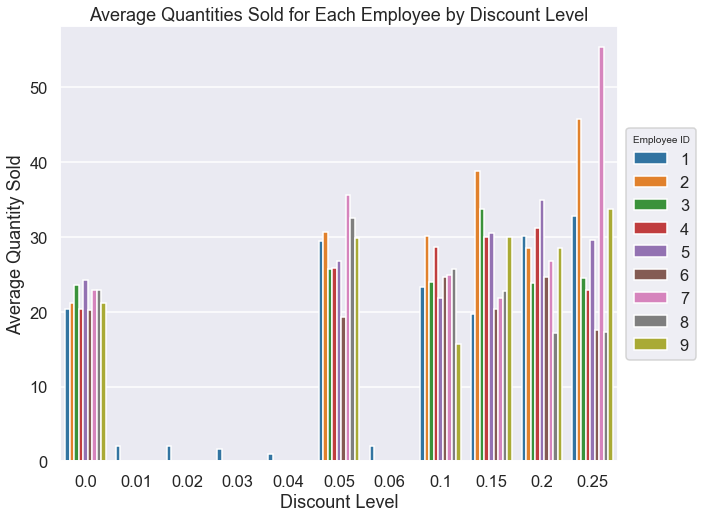

In [29]:
plt.figure(figsize=(10,8))
bars = sns.barplot(x=q3.Discount, y= q3.Quantity, hue=q3.EmployeeId, ci=None)
bars.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Average Quantities Sold for Each Employee by Discount Level")
plt.ylabel("Average Quantity Sold")
plt.xlabel("Discount Level")
bars.legend(title = 'Employee ID', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

There are noticeable differences between employees at each discount level. Let's run an ANOVA testing the effect of discount level and employee ID on the quantity of items sold with an alpha level of .05.

### ANOVA

In [30]:
discounted = q3[q3.Discounted == 1]
formula = 'Quantity ~ C(Discount) + C(EmployeeId)'
lm = ols(formula, discounted).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(Discount),5959.816383,9.0,1.566853,0.120863
C(EmployeeId),8212.888682,8.0,2.429091,0.013451
Residual,346558.120674,820.0,NaN,NaN


There is a significant effect between employee ID (p-value = .01) and the quantity of discounted items sold, but there is not a significant effect for the discount level (p-value = .12).  

## Question 4: Are certain types of items more likely to be discounted?

Finally we are going to look at the categories of our products. We are going to see if different categories are more likely to be discounted.

$H_O$: There will be no differences in discount level between product categories.

$H_A$: There will be significant differences in discount level between product categories.

### Query the database

In [31]:
SQL_reader('Category')

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,6,Meat/Poultry,Prepared meats
6,7,Produce,Dried fruit and bean curd
7,8,Seafood,Seaweed and fish


In [32]:
selected = ['ProductName', 'Discount', 'CategoryId', 'CategoryName']
tables = ['Product p', 'OrderDetail od', 'Category c']
joins = ['p.ID = od.ProductID', 'p.CategoryId = c.Id']
q4 = SQL_joiner(selected, tables, joins, verbose=True)
print(len(q4))
q4.head()

select ProductName, Discount, CategoryId, CategoryName from Product p join OrderDetail od on p.ID = od.ProductID join Category c on p.CategoryId = c.Id
2155


,ProductName,Discount,CategoryId,CategoryName
0,Queso Cabrales,0.0,4,Dairy Products
1,Singaporean Hokkien Fried Mee,0.0,5,Grains/Cereals
2,Mozzarella di Giovanni,0.0,4,Dairy Products
3,Tofu,0.0,7,Produce
4,Manjimup Dried Apples,0.0,7,Produce


### Exploratory Analysis

Let's take a look at a barchart of our data. We will look at the average discount level for each category.

Text(0.5, 1.0, 'Average Discount by Category')

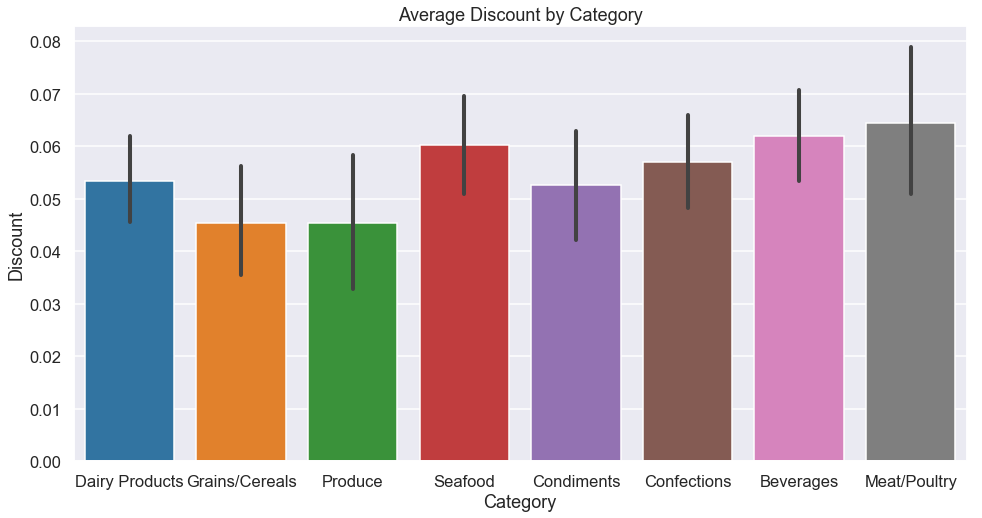

In [33]:
fig = plt.figure(figsize=(16,8))
sns.barplot(q4.CategoryName, q4.Discount)
plt.xlabel('Category')
plt.ylabel('Discount')
plt.title('Average Discount by Category')

It looks like the categories have pretty similar discount levels.  Let's run an ANOVA with an alpha level of .05 to test if there is a significant difference present.

In [34]:
formula = 'Discount ~ C(CategoryId)'
lm = ols(formula, q4).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(CategoryId),0.074918,7.0,1.539545,0.149326
Residual,14.925422,2147.0,NaN,NaN


With a p-value of .149, we cannot reject the null hypothesis. There is no significant difference in discount levels between types of products.

## Summary

1. Discount does have a significant effect on the quantity of items ordered, but the level of discount is not significant.
2. Customers who order more often from Northwind Traders have a significantly higher discount level.  Similarly, customers who spend more at Northwind Traders have a signifiantly higher discount level.
3. Some employees sell significantly more discounted items than other employees, but there is no effect by discount level.
4. There is no significant difference in discount level between categories of products.